In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [14]:
df = pd.read_csv("data.csv")
df = df.drop(columns=["Game", "Month", "Year","Genre","rank_category","Release_Month","Release_Year","New_Game", "Wrong"])
df

,Rank,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,94377226,1362044,530270,2903,129172,127021,1833,69.29
1,2,47832863,830105,372654,2197,120849,64378,1117,57.62
2,3,45185893,433397,315083,1100,44074,60815,583,104.26
3,4,39936159,235903,131357,517,36170,53749,317,169.29
4,5,16153057,1151578,71639,3620,214054,21740,1549,14.03
...,...,...,...,...,...,...,...,...,...
20995,196,683902,10093,10600,42,1443,951,14,67.76
20996,197,683226,37779,39473,116,7076,950,52,18.08
20997,198,679965,28491,2539,75,1066,945,39,23.87
20998,199,673799,16675,19746,210,957,937,23,40.41


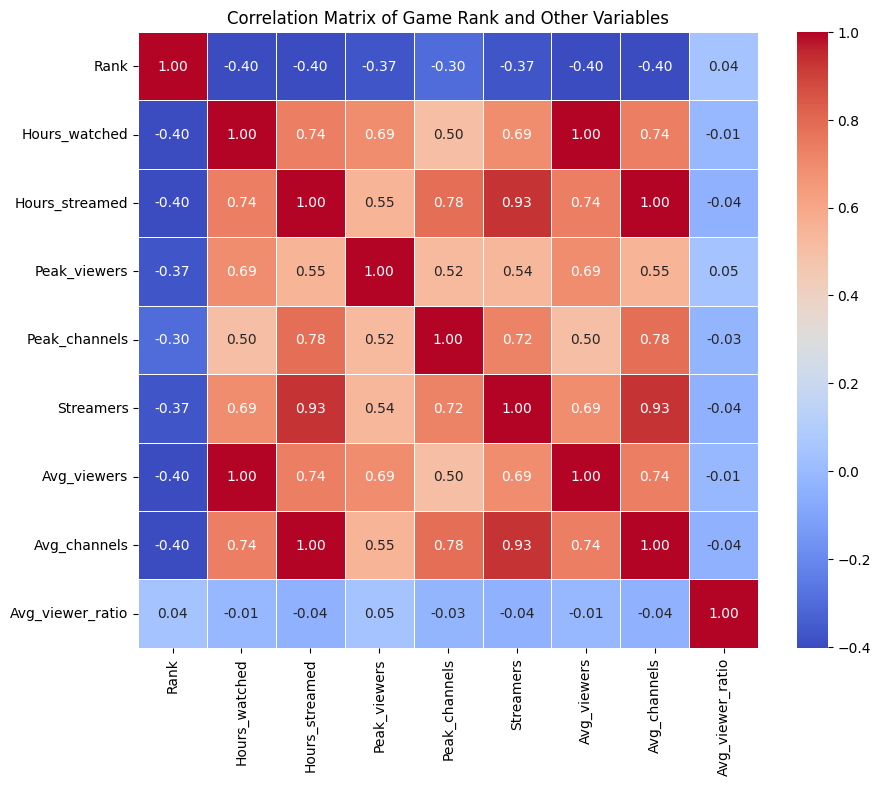

In [19]:
# Compute the correlation matrix
correlation_matrix = df.corr()
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Game Rank and Other Variables")
plt.show()

In [20]:
# Identify the most relevant variables to Rank using correlation
rank_correlation = df.corr()["Rank"].sort_values()

# Display the most relevant variables (excluding self-correlation with Rank)
most_relevant_variables = rank_correlation.drop("Rank")

# Display the results
most_relevant_variables

Hours_watched      -0.402867
Avg_viewers        -0.402842
Avg_channels       -0.399713
Hours_streamed     -0.399622
Streamers          -0.374219
Peak_viewers       -0.371577
Peak_channels      -0.302693
Avg_viewer_ratio    0.044131
Name: Rank, dtype: float64

In [23]:
#Load training and testing data files using latin1 encoding
train_df = pd.read_csv("train_data.csv", encoding="latin1")
test_df = pd.read_csv("test_data.csv", encoding="latin1")

# Drop unnecessary columns if they exist
drop_columns = ["Game", "Month", "Year"]
train_df = train_df.drop(columns=drop_columns, errors='ignore')
test_df = test_df.drop(columns=drop_columns, errors='ignore')

#Create the rank_category column based on Rank for both datasets
def assign_category(rank):
    if rank <= 10:
        return "top10"
    elif rank <= 50:
        return "top50"
    elif rank <= 100:
        return "top100"
    elif rank <= 200:
        return "top200"
    else:
        return "others"

train_df['rank_category'] = train_df['Rank'].apply(assign_category)
test_df['rank_category'] = test_df['Rank'].apply(assign_category)

# Filter out rows that are not in our desired categories
desired_categories = ["top10", "top50", "top100", "top200"]
train_df = train_df[train_df['rank_category'].isin(desired_categories)]
test_df = test_df[test_df['rank_category'].isin(desired_categories)]

#Define the predictor variables to evaluate
predictors = ["Avg_channels", "Hours_streamed", "Avg_viewers", "Hours_watched"]

# Dictionary to store F1 scores for each predictor and each category
results = {}
results_R_RMSE = {}
rank_mapping = {"top10": 10, "top50": 50, "top100": 100, "top200": 200}
# Evaluate each predictor using a multinomial logistic regression model
for predictor in predictors:
    # Prepare training and testing data using the current predictor
    X_train = train_df[[predictor]]
    y_train = train_df['rank_category']
    
    X_test = test_df[[predictor]]
    y_test = test_df['rank_category']
    
    # Train the multinomial logistic regression model
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    y_test_numeric = y_test.map(rank_mapping)
    y_pred_numeric = pd.Series(y_pred).map(rank_mapping)
    
    # Compute R^2 and RMSE
    r2 = r2_score(y_test_numeric, y_pred_numeric)
    rmse = np.sqrt(mean_squared_error(y_test_numeric, y_pred_numeric))
    
    results_R_RMSE[predictor] = {"R^2": r2, "RMSE": rmse}

    
    # Generate a classification report and extract F1 scores for each category
    report = classification_report(y_test, y_pred, output_dict=True)
    category_scores = {}
    for cat in desired_categories:
        category_scores[cat] = report.get(cat, {}).get("f1-score", 0)
    
    results[predictor] = category_scores

# Create a DataFrame to display the F1 scores for each predictor and category
results_df = pd.DataFrame(results).T  # predictors as rows, categories as columns
print("F1 Scores for each predictor and category(MLR):")
print(results_df)

#Rank the predictors for each category based on their F1 scores
ranking = {}
for cat in results_df.columns:
    sorted_predictors = results_df[cat].sort_values(ascending=False)
    ranking[cat] = sorted_predictors

print("\nRanking of predictors for each category based on F1 score(MLR):")
for cat, sorted_series in ranking.items():
    print(f"\nCategory: {cat}")
    print(sorted_series)

results_df = pd.DataFrame(results_R_RMSE).T
print("R^2 and RMSE for each predictor using multinomial logistic regression:")
print(results_df)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

F1 Scores for each predictor and category(MLR):
                   top10     top50    top100    top200
Avg_channels    0.702179  0.560597  0.275787  0.778383
Hours_streamed  0.703883  0.559585  0.271094  0.779338
Avg_viewers     0.941995  0.801170  0.606639  0.870360
Hours_watched   0.945626  0.795958  0.616262  0.893045

Ranking of predictors for each category based on F1 score(MLR):

Category: top10
Hours_watched     0.945626
Avg_viewers       0.941995
Hours_streamed    0.703883
Avg_channels      0.702179
Name: top10, dtype: float64

Category: top50
Avg_viewers       0.801170
Hours_watched     0.795958
Avg_channels      0.560597
Hours_streamed    0.559585
Name: top50, dtype: float64

Category: top100
Hours_watched     0.616262
Avg_viewers       0.606639
Avg_channels      0.275787
Hours_streamed    0.271094
Name: top100, dtype: float64

Category: top200
Hours_watched     0.893045
Avg_viewers       0.870360
Hours_streamed    0.779338
Avg_channels      0.778383
Name: top200, dtype: floa

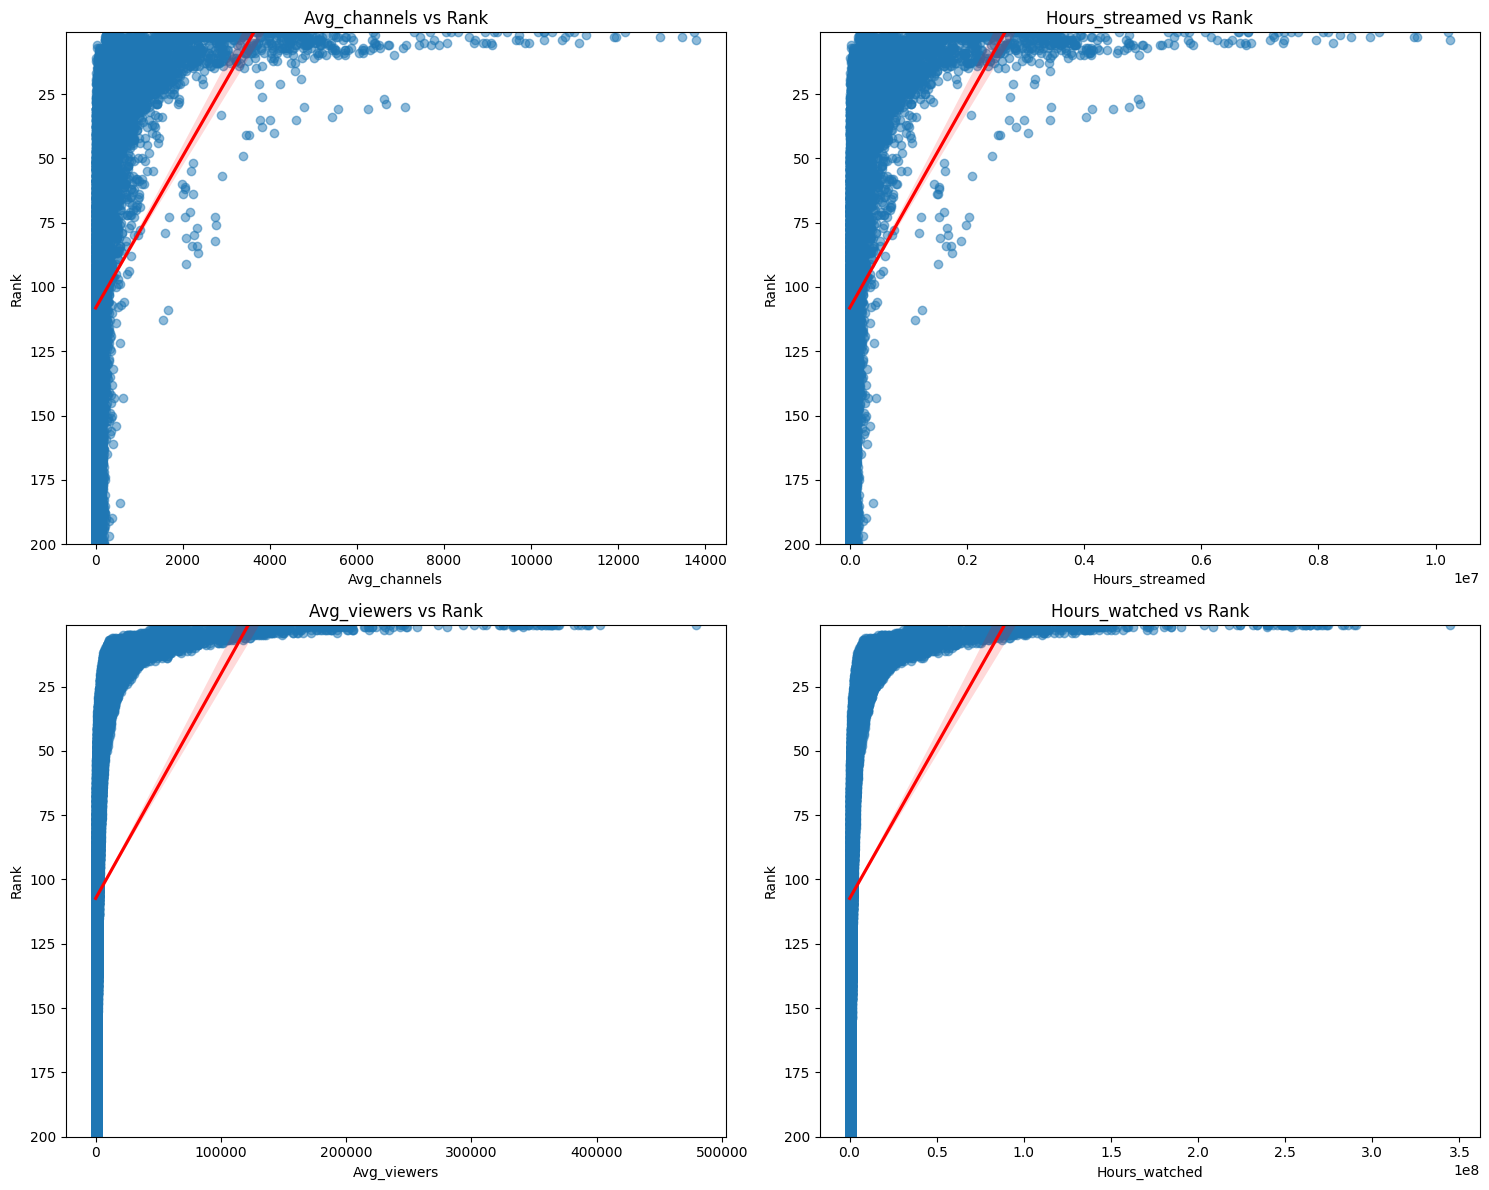

In [4]:
target = "Rank"

#Create a 2x2 subplot for the four scatter plots with regression lines
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()

#Generate scatter plots with regression lines for each predictor vs. Rank
for i, predictor in enumerate(predictors):
    sns.regplot(x=predictor, y=target, data=df, ax=axs[i], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
    axs[i].set_title(f"{predictor} vs {target}")
    axs[i].set_xlabel(predictor)
    axs[i].set_ylabel(target)
    axs[i].set_ylim(1, 200)
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()

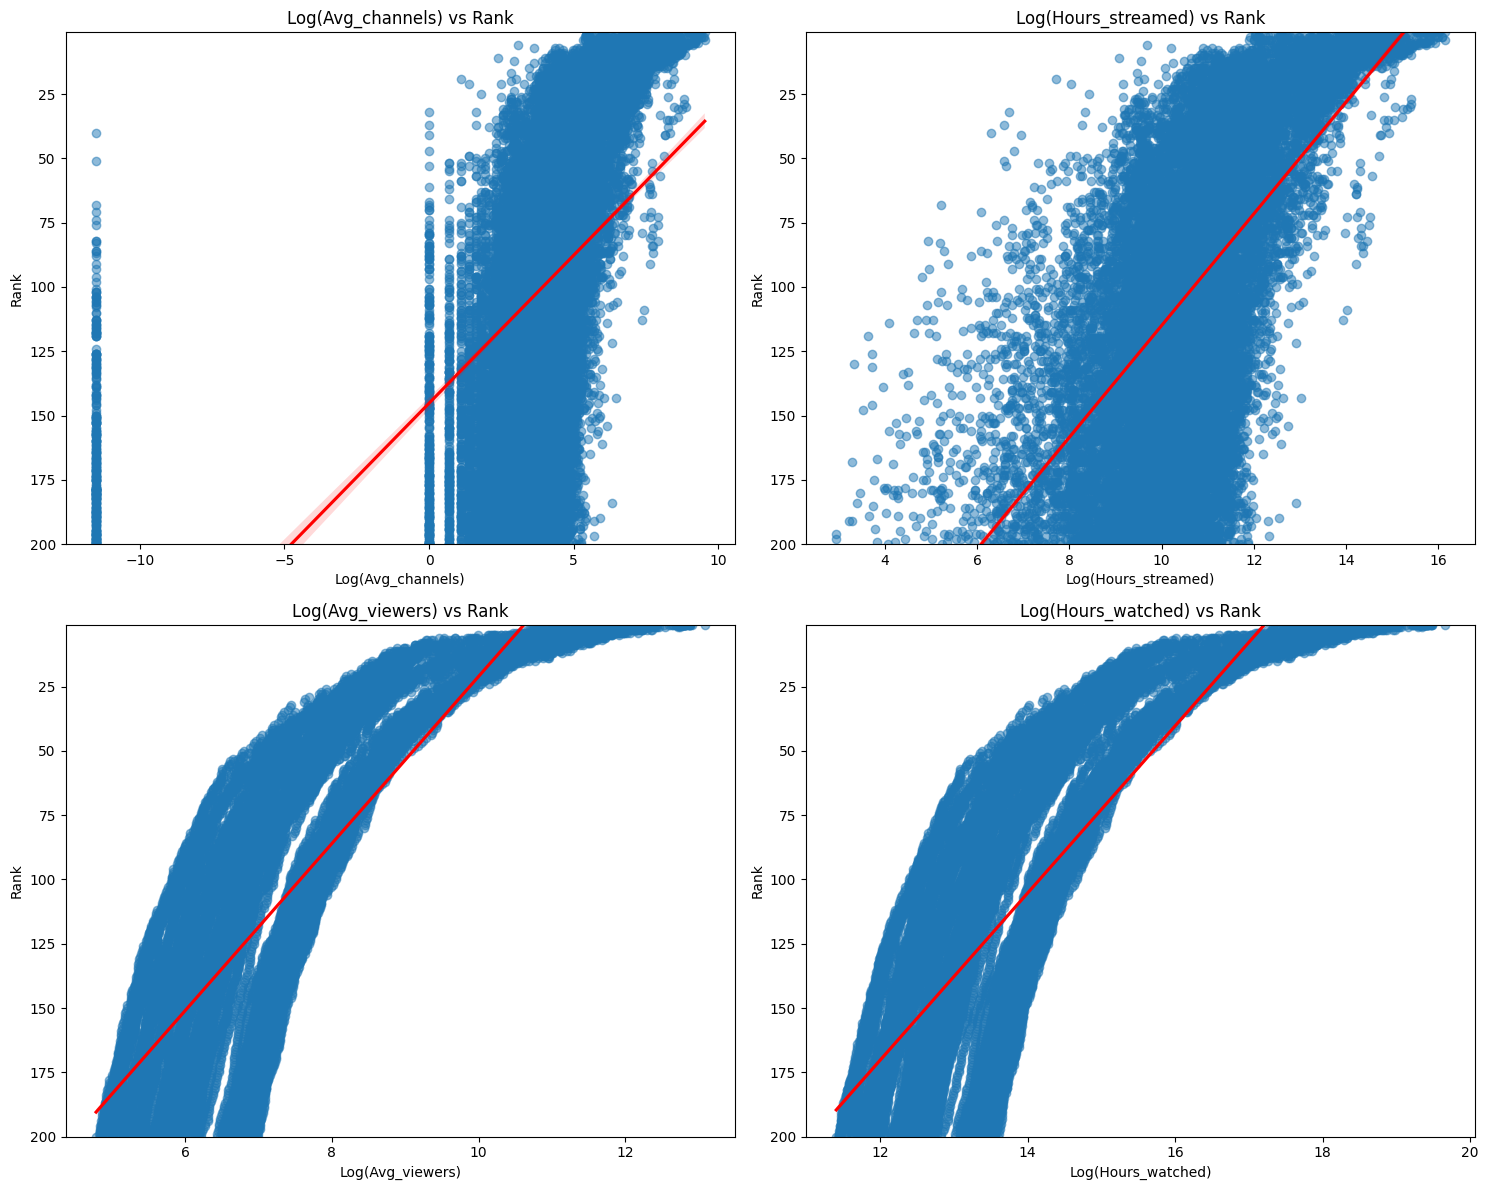

In [5]:
epsilon = 1e-5  # a small constant to avoid log(0)
results = {}
for col in predictors:
    df[col] = df[col].apply(lambda x: x if x > 0 else epsilon)

# Create new columns for log-transformed predictors
for col in predictors:
    df[f"log_{col}"] = np.log(df[col])

# Plot scatter plots with regression lines: log-transformed predictor vs. Rank
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()

for i, col in enumerate(predictors):
    log_col = f"log_{col}"
    sns.regplot(x=log_col, y=target, data=df, ax=axs[i],
                scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})
    axs[i].set_title(f"Log({col}) vs {target}")
    axs[i].set_xlabel(f"Log({col})")
    axs[i].set_ylabel(target)
    axs[i].set_ylim(1, 200)
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()



In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load the data using latin1 encoding
df = pd.read_csv("Twitch_game_data.csv", encoding="latin1")

# 2. Drop unnecessary columns if they exist
df = df.drop(columns=["Game", "Month", "Year"], errors="ignore")

# 3. Ensure the dependent variable (Rank) is positive (if not, adjust accordingly)
# Here we assume Rank > 0; otherwise, replace non-positive values with 1 (or a small constant)
df["Rank"] = df["Rank"].apply(lambda x: x if x > 0 else 1)

# 4. Log-transform the dependent variable
df["log_Rank"] = np.log(df["Rank"])

# 5. Define the predictor variables
predictors = ["Avg_channels", "Hours_streamed", "Avg_viewers", "Hours_watched"]

# 6. For each predictor, train a linear regression model to predict the log-transformed Rank,
#    and compute the R² and RMSE
results = {}
for col in predictors:
    X = df[[col]]
    y = df["log_Rank"]
    
    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict on the same data (or use separate test data if available)
    y_pred = model.predict(X)
    
    # Compute R² and RMSE
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    results[col] = {"R^2": r2, "RMSE": rmse}

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T
print("Linear Regression Metrics (with logged dependent variable) for each predictor:")
print(results_df)


Linear Regression Metrics (with logged dependent variable) for each predictor:
                     R^2      RMSE
Avg_channels    0.383505  0.747551
Hours_streamed  0.383346  0.747647
Avg_viewers     0.479428  0.686936
Hours_watched   0.479503  0.686886
